In [3]:
import numpy as np
import pandas as pd
from utils import *

/Users/shamanthk/.pyenv/versions/3.10.14/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = load_from_csv('/Users/shamanthk/Documents/iomics/DoWhy-workflow/data/lung_cancer.csv')
df = df.dropna()
df.drop_duplicates(inplace=True)
labels = list(df.columns)
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [5]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

cols = df.columns[(df == 1).any() | (df == 2).any()]
df[cols] = df[cols].replace({1: 0, 2: 1})

df['LUNG_CANCER']=encoder.fit_transform(df['LUNG_CANCER'])
df['GENDER']=encoder.fit_transform(df['GENDER'])
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,69,0,1,1,0,0,1,0,1,1,1,1,1,1,1
1,1,74,1,0,0,0,1,1,1,0,0,0,1,1,1,1
2,0,59,0,0,0,1,0,1,0,1,0,1,1,0,1,0
3,1,63,1,1,1,0,0,0,0,0,1,0,0,1,1,0
4,0,63,0,1,0,0,0,0,0,1,0,1,1,0,0,0


#### Let's ask the question: Does smoking cause lung cancer?

We should know from a large number of studies that, yes, smoking does cause lung cancer -- how can we test this out using DoWhy?

In [6]:
df = df.astype(float)
df.shape

In [7]:
import dowhy

In [8]:
data = df.to_numpy()
data

array([[ 1., 69.,  0., ...,  1.,  1.,  1.],
       [ 1., 74.,  1., ...,  1.,  1.,  1.],
       [ 0., 59.,  0., ...,  0.,  1.,  0.],
       ...,
       [ 1., 55.,  1., ...,  0.,  1.,  0.],
       [ 1., 46.,  0., ...,  1.,  1.,  0.],
       [ 1., 60.,  0., ...,  1.,  1.,  1.]])

#### First let us choose a candidate model

However, to do so, we should consider a few of the main causal discovery algorithms

In [9]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ScoreBased.GES import ges
from causallearn.search.FCMBased import lingam
from causallearn.search.FCMBased.lingam.utils import make_dot
from causallearn.search.ConstraintBased.FCI import fci


For now, let us stick to ICA LiNGAM for purposes of demonstration. Pretend that we have already gone through the list and this is the algorithm that we have deciced to stick with.

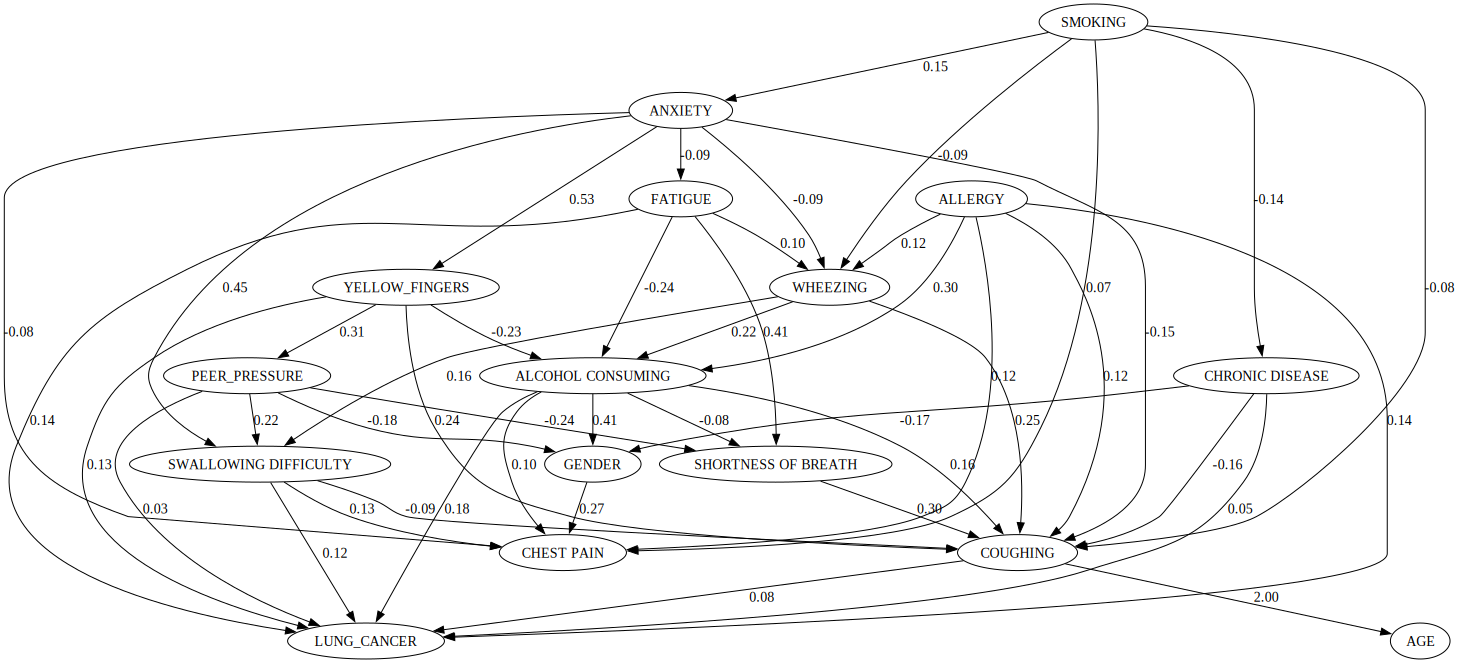

In [10]:
model = lingam.ICALiNGAM()
model.fit(data)

make_dot(model.adjacency_matrix_, labels=labels)

In [11]:
dot = make_dot(model.adjacency_matrix_, labels=labels)
dot.save('temp.dot')
predicted_graph_lingam = nx.drawing.nx_agraph.read_dot('temp.dot')

#### Graph refutation

Test permutations of given graph: 100%|██████████| 200/200 [01:09<00:00,  2.86it/s]


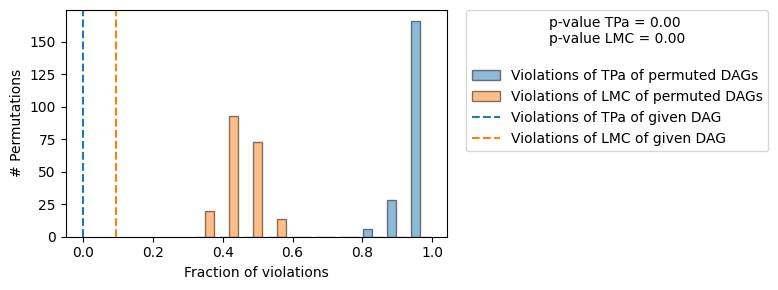

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 0 / 200 of the permutations lie in the Markov                    |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 10/105 LMCs and is better than 100.0% of the permuted DAGs (p-value: 0.00).    |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+
|                                             

In [12]:
import dowhy.gcm.falsify
from dowhy.gcm.falsify import falsify_graph

# causal_graph is a networkx digraph
results = falsify_graph(predicted_graph_lingam, df, n_permutations=200,
                              independence_test=gcm,
                              conditional_independence_test=gcm,
                              plot_histogram=True, suggestions=True)
print(results)

In [13]:
from dowhy.gcm.falsify import apply_suggestions

predicted_graph_lingam = apply_suggestions(predicted_graph_lingam, results)

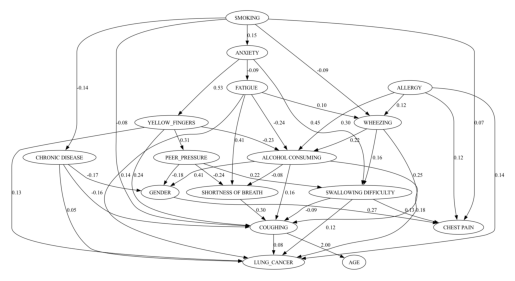

In [14]:
disp_graph_nx(predicted_graph_lingam)

In [15]:
nx.write_gml(predicted_graph_lingam, '/Users/shamanthk/Documents/iomics/DoWhy-workflow/lingam.gml')

In [16]:
from dowhy import CausalModel

model_est=CausalModel(
        data = df,
        treatment='SMOKING',
        outcome='LUNG_CANCER',
        graph='lingam.gml')

In [17]:
identified_estimand = model_est.identify_effect(proceed_when_unidentifiable=False)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                     
──────────(E[LUNG_CANCER])
d[SMOKING]                
Estimand assumption 1, Unconfoundedness: If U→{SMOKING} and U→LUNG_CANCER then P(LUNG_CANCER|SMOKING,,U) = P(LUNG_CANCER|SMOKING,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [18]:
estimate = model_est.estimate_effect(identified_estimand,
                                method_name="backdoor.linear_regression",
                                control_value=0,
                                treatment_value=1,
                                confidence_intervals=True,
                                test_significance=True)
print("Causal Estimate is " + str(estimate.value))

Causal Estimate is 0.02602010006901334


In [19]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                     
──────────(E[LUNG_CANCER])
d[SMOKING]                
Estimand assumption 1, Unconfoundedness: If U→{SMOKING} and U→LUNG_CANCER then P(LUNG_CANCER|SMOKING,,U) = P(LUNG_CANCER|SMOKING,)

## Realized estimand
b: LUNG_CANCER~SMOKING+SMOKING*ALLERGY 
Target units: 

## Estimate
Mean value: 0.02602010006901334
p-value: [0.33600501]
95.0% confidence interval: (-0.05260646157385196, 0.10483454862401631)
### Conditional Estimates
__categorical__ALLERGY 
(-0.001, 1.0]    0.02602
dtype: float64


In [20]:
estimate.get_confidence_intervals()

In [21]:
estimate.interpret()

Increasing the treatment variable(s) [SMOKING] from 0 to 1 causes an increase of 0.02602010006901334 in the expected value of the outcome [['LUNG_CANCER']], over the data distribution/population represented by the dataset.


In [22]:
refute_placebo_treatment = model_est.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter",
    placebo_type="permute"
)

print(refute_placebo_treatment)

Refute: Use a Placebo Treatment
Estimated effect:0.02602010006901334
New effect:-0.0007638416296782712
p value:0.98



In [23]:
res_random=model_est.refute_estimate(identified_estimand, estimate, method_name="random_common_cause", show_progress_bar=True)
print(res_random)

Refuting Estimates: 100%|██████████| 100/100 [00:00<00:00, 119.27it/s]

Refute: Add a random common cause
Estimated effect:0.02602010006901334
New effect:0.025709726224321657
p value:0.82



In [24]:
res_subset=model_est.refute_estimate(identified_estimand, estimate,
       method_name="data_subset_refuter", show_progress_bar=True, subset_fraction=0.9)
print(res_subset)

Refuting Estimates: 100%|██████████| 100/100 [00:00<00:00, 139.33it/s]

Refute: Use a subset of data
Estimated effect:0.02602010006901334
New effect:0.025185614298961028
p value:0.86

